In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
class Segment:
    
    def __init__(self, start_index, end_index, frames, bounds):
        self.start_index = start_index
        self.end_index = end_index
        self.frames = frames
        self.bounds = bounds

class Track:
    
    def __init__(self, tag, clip_key, track_key, start_time, end_time, segments):
        self.tag = tag
        self.clip_key = clip_key
        self.track_key = track_key
        self.start_time = start_time
        self.end_time = end_time
        self.segments = segments
        self.segment_count = len(segments)
        self.frame_count = np.sum([len(s.frames) for s in segments])

In [3]:
with open('/home/dennis/projects/cacophony/irvideo/usable-data.pk', 'rb') as f:
    usable_data = pickle.load(f)

In [4]:
mins = []
maxs = []
for tag in usable_data:
    tracks = usable_data[tag]
    for track in tracks:
        for segment in track.segments:
            mins.append(np.min(segment.bounds, axis=0))
            maxs.append(np.max(segment.bounds, axis=0))
print(f'mins = {np.min(np.array(mins), axis=0)}, maxs = {np.max(np.array(maxs), axis=0)}')

mins = [1 1 7 7], maxs = [153 113 159 119]


In [5]:
def center_position(low_bound, high_bound, low_limit, high_limit, space):
    size = high_bound - low_bound
    extra = space - size
    if extra > 0:
        if low_bound == low_limit:
            return 0, size
        elif high_bound == high_limit:
            return space-size, space
        else:
            pad = int(extra/2) + np.random.randint(extra%2 + 1)
            return pad, size+pad
    else:
        return 0, size
    
def fill_rows(frame, fill_high, space):
    f = np.zeros((space, frame.shape[1]))
    #print(f'frame {frame.shape}, f {f.shape}')
    if fill_high:
        f[:frame.shape[0],:] = frame
    else:
        f[space-frame.shape[0]:,:] = frame
    return f
    
def fill_cols(frame, fill_high, space):
    f = np.zeros((frame.shape[0], space))
    if fill_high:
        f[:,:frame.shape[1]] = frame
    else:
        f[:,space-frame.shape[1]:] = frame
    return f

print(center_position(1, 10, 1, 20, 15))
print(center_position(11, 20, 1, 20, 15))
print(center_position(5, 14, 1, 20, 15))
ones = np.ones((2,3))
print(fill_rows(ones, False, 4))
print(fill_rows(ones, True, 4))
print(fill_cols(ones, False, 4))
print(fill_cols(ones, True, 4))
print(fill_cols(fill_rows(ones, False, 4), False, 4))

(0, 9)
(6, 15)
(3, 12)
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 1. 1. 1.]
 [0. 1. 1. 1.]]
[[1. 1. 1. 0.]
 [1. 1. 1. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [0. 1. 1. 1.]]


In [6]:
# bounds order: [left,top,right,bottom]
min_left = 1
min_top = 1
max_right = 159
max_bottom = 119
edge_bounds = [min_left, min_top, max_right, max_bottom]
out_dim = 32
out_tracks = []
for tag in usable_data:
    for track in usable_data[tag]:
        for segment in track.segments:
            frames = segment.frames
            for index, frame in enumerate(frames):
                maxdim = max(frame.shape)
                f = frame
                bounds = segment.bounds[index]
                if maxdim > out_dim:
                    mindim = min(f.shape)
                    diff = maxdim - mindim
                    if diff:
                        f = np.zeros((maxdim,maxdim))
                        c0, c1 = center_position(bounds[0], bounds[2], min_left, max_right, maxdim)
                        r0, r1 = center_position(bounds[1], bounds[3], min_top, max_bottom, maxdim)
                        f[r0:r1,c0:c1] = frame
                    if any(a == b for a,b in zip(bounds, edge_bounds)):
                        dim = out_dim
                    else:
                        dim = maxdim - int((maxdim - out_dim) / 4 + 1) * 4
                    f = cv2.resize(f, (dim,dim), interpolation=cv2.INTER_AREA)
                    #print(f'resized image of size {frame.shape} with bounds {bounds} to size {f.shape}')
                else:
                    if bounds[0] == min_left:
                        f = fill_cols(f, True, out_dim)
                    elif bounds[2] == max_right:
                        f = fill_cols(f, False, out_dim)
                    if bounds[1] == min_top:
                        f = fill_rows(f, True, out_dim)
                    elif bounds[3] == max_bottom:
                        f = fill_rows(f, False, out_dim)
                f = f.astype(np.float32)
                maxval = f.max()
                f = f / maxval
                frames[index] = f
        out_tracks.append(track)

In [7]:
tag_tracks = {}
for track in out_tracks:
    tag = track.tag
    if tag in tag_tracks:
        tag_tracks[tag] += 1
    else:
        tag_tracks[tag] = 1
tag_tracks

{'hedgehog': 1551,
 'unknown': 599,
 'false-positive': 4443,
 'rodent': 5023,
 'possum': 1623,
 'cat': 842,
 'bird': 1620,
 'mustelid': 666,
 'insect': 432,
 'human': 229,
 'leporidae': 836,
 'poor tracking': 32,
 'sheep': 87,
 'part': 82,
 'bird/kiwi': 99,
 'sealion': 1,
 'wallaby': 1180,
 'pig': 1}

In [8]:
with open('/home/dennis/projects/cacophony/irvideo/usable-data-sized.pk', 'wb') as f:
    for track in out_tracks:
        pickle.dump(track, f)

 tag rodent, frame shape (32, 23), original bounds [111 105 134 119]


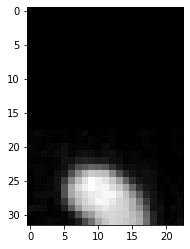

 tag rodent, frame shape (32, 18), original bounds [ 31 109  49 119]


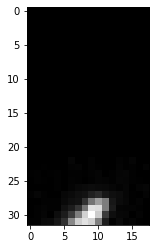

 tag unknown, frame shape (11, 32), original bounds [149  10 159  21]


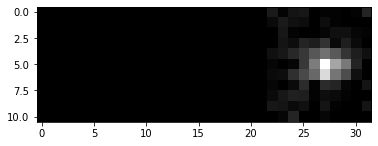

 tag possum, frame shape (28, 28), original bounds [ 81  40 129  74]


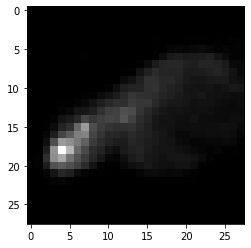

 tag bird, frame shape (30, 30), original bounds [24 14 48 68]


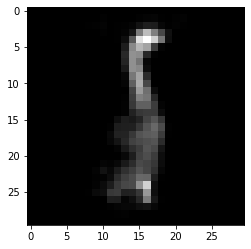

 tag false-positive, frame shape (32, 32), original bounds [150   1 159  12]


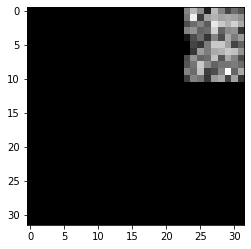

 tag possum, frame shape (20, 32), original bounds [139  34 159  54]


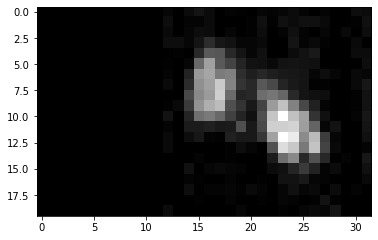

 tag false-positive, frame shape (32, 32), original bounds [ 14   1 103  90]


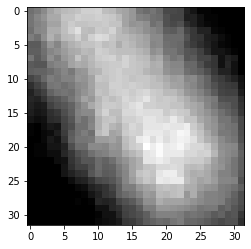

 tag false-positive, frame shape (32, 32), original bounds [100   1 152  20]


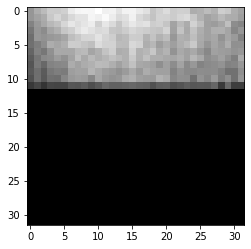

 tag false-positive, frame shape (32, 32), original bounds [146   1 159  15]


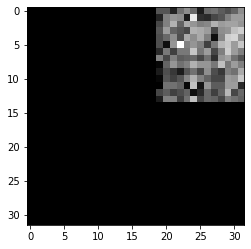

In [10]:
show_count = 0
while show_count < 10:
    track = out_tracks[np.random.randint(len(out_tracks))]
    segment = track.segments[np.random.randint(len(track.segments))]
    index = np.random.randint(len(segment.frames))
    frame = segment.frames[index]
    if max(frame.shape) >= 28:
        print(f' tag {track.tag}, frame shape {frame.shape}, original bounds {segment.bounds[index]}')
        plt.imshow(frame, cmap='gray')
        plt.show()
        show_count += 1

In [11]:
del usable_data